## This notebook makes summary plots, after MCs have been run

  - Recall that in the earlier pipeline stage `05_exploratory_plots.ipynb`, we plotted some quantities such as $P_{gv}(k)$, but didn't assign error bars, since we used a limited number ($\sim$ 5) of Monte Carlos.

  - This notebook uses output files `pk_*.npy` from the previous pipeline stage (`06_run_sims.ipynb`) to make these plots with less statistical noise, and proper error bars.

  - We also do some comparisons between mocks and surrogates, to partially validate the surrogate formalism.

#### Input files

 - `pk_data.npy`: contains power spectra $P_{gg}$, $P_{gv}$, $P_{vv}$ of SDSS data, for two velocity reconstructions (90 and 150 GHz). File format is a single `(nfields,nfields,nkbins)` numpy array, where the `nfields` axes have length 3 and corrresponds to fields {gal, v90, v150}.

 - `pk_mocks.npy`: contains power spectra $P_{gg}$, $P_{gv}$, $P_{vv}$ of SDSS **mocks**. File format is a single `(nmocks,nfields,nfields,nkbins)` numpy array, where the `nfields` axes have length 3 and corrresponds to fields {gal, v90, v150}.

 - `pk_surrogates.npy`: contains power spectra $P_{gg}$, $P_{gv}$, $P_{vv}$ of SDSS **surrogates**. File format is a single `(nsurr,nfnl,nfields,nfields,nkbins)` numpy array. The `nfnl` axis has length 3 and corresponds to $f_{NL} = (-250,0,250)$. The `nfields` axes have length 3 and corrrespond to fields {gal, v90, v150}.

## Imports and global variables

In [1]:
import kszx
import numpy as np
import matplotlib.pyplot as plt

In [2]:
# File 'global_params.py' in current directory
import global_params

nkbins = global_params.nkbins
kbin_edges = global_params.kbin_edges
kbin_centers = global_params.kbin_centers
nmocks = global_params.sdss_nmocks
nsurr = global_params.num_surrogates
surr_fnl = global_params.surr_fnl

## Read input files

In [3]:
pk_data = kszx.io_utils.read_npy('pk_data.npy')
pk_mocks = kszx.io_utils.read_npy('pk_mocks.npy')
pk_surr = kszx.io_utils.read_npy('pk_surrogates.npy')

Reading pk_data.npy
Reading pk_mocks.npy
Reading pk_surrogates.npy


In [4]:
print(f'{pk_data.shape=}')
print(f'[Expect (3,3,{nkbins=}), first two axes are {{g,vr90,vr150}}]\n')

print(f'{pk_mocks.shape=}')
print(f'[Expect ({nmocks=},3,3,nkbins=), middle two axes are {{g,vr90,vr150}}]\n')

print(f'{pk_surr.shape=}')
print(f'[Expect ({nsurr=},3,3,3,nkbins=), second axis is fnl={{-{surr_fnl},0,{surr_fnl}}},'
      + f' third+fourth axes are {{g,vr90,vr150}}]')

pk_data.shape=(3, 3, 100)
[Expect (3,3,nkbins=100), first two axes are {g,vr90,vr150}]

pk_mocks.shape=(1000, 3, 3, 100)
[Expect (nmocks=1000,3,3,nkbins=), middle two axes are {g,vr90,vr150}]

pk_surr.shape=(1000, 3, 3, 3, 100)
[Expect (nsurr=1000,3,3,3,nkbins=), second axis is fnl={-250,0,250}, third+fourth axes are {g,vr90,vr150}]


## $P_{gg}(k)$ plots

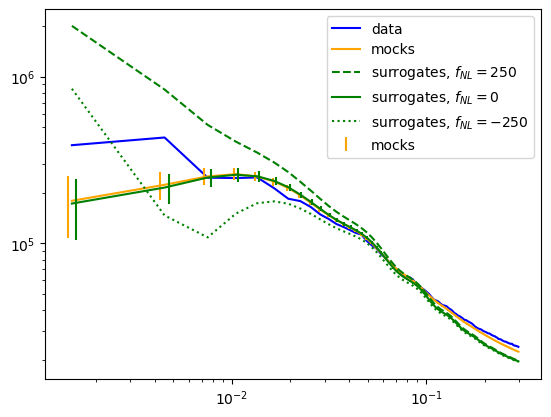

In [5]:
pgg_data = pk_data[0,0,:]                       # shape (nkbins,)
pgg_mocks = np.mean(pk_mocks[:,0,0,:], axis=0)  # shape (nkbins,)
dpgg_mocks = np.var(pk_mocks[:,0,0,:], axis=0)**0.5   # shape (nkbins,)
pgg_surr = np.mean(pk_surr[:,:,0,0,:], axis=0)  # shape (3,nkbins), first axis is fnl=[-250,0,250]
dpgg_surr = np.var(pk_surr[:,:,0,0,:], axis=0)**0.5   # shape (3,nkbins)

# visually offset error bars
dk = np.minimum(0.05*kbin_centers, 0.1 * (kbin_edges[1:] - kbin_edges[:-1]))

plt.plot(kbin_centers, pgg_data, label='data', color='blue')

plt.plot(kbin_centers, pgg_mocks, label=f'mocks', color='orange')
plt.errorbar(kbin_centers-dk, pgg_mocks, yerr=dpgg_mocks, ls='none', label=f'mocks', color='orange')

plt.plot(kbin_centers, pgg_surr[2,:], label=f'surrogates, $f_{{NL}}={surr_fnl}$', color='green', ls='--')
plt.plot(kbin_centers, pgg_surr[1,:], label=f'surrogates, $f_{{NL}}=0$', color='green', ls='-')
plt.plot(kbin_centers, pgg_surr[0,:], label=f'surrogates, $f_{{NL}}={-surr_fnl}$', color='green', ls=':')
plt.errorbar(kbin_centers+dk, pgg_surr[1,:], yerr=dpgg_surr[1,:], ls='none', color='green')

plt.legend(loc='upper right')
plt.xscale('log')
plt.yscale('log')
plt.show()

## $P_{gv}(k)$ plots.

 - 150 GHz looks good, except for a puzzling "dip" at k=0.03.
 - 90 GHz shows large-scale systematic power.
 - We show $P_{gv}$ for surrogates, but not for mocks. This is because the velocity reconstruction of the mock catalogs is pure reconstruction noise (it's obtained by using real ACT data and mock SDSS data, which is one reasonable way of simulating the reconstruction noise, but doesn't contain a simulated velocity field).

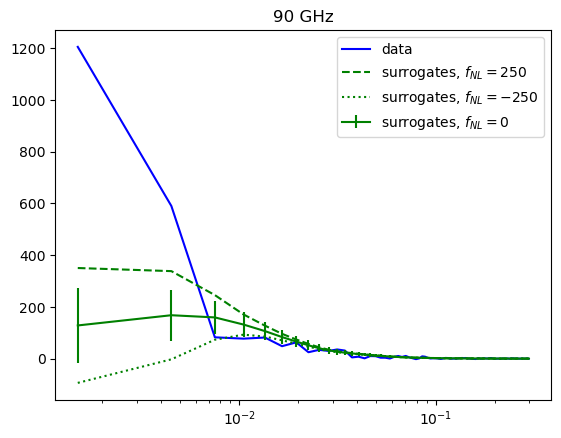

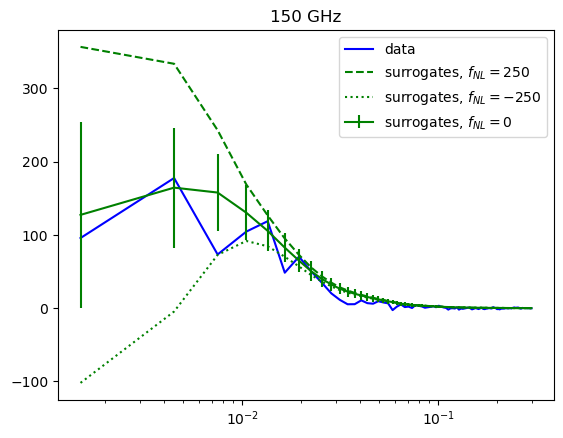

In [6]:
pgv_data = pk_data[0,1:,:]                       # shape (2,nkbins), first axis is [90,150] GHz
pgv_mocks = np.mean(pk_mocks[:,0,1:,:], axis=0)  # shape (2,nkbins), first axis is [90,150] GHz
pgv_surr = np.mean(pk_surr[:,:,0,1:,:], axis=0)  # shape (3,2,nkbins), first axis is fnl=[-250,0,250]
dpgv_surr = np.var(pk_surr[:,:,0,1:,:], axis=0)**0.5   # shape (3,2,nkbins)

def plot_pgv(ifreq, title):
    plt.plot(kbin_centers, pgv_data[ifreq], label='data', color='blue')
    plt.plot(kbin_centers, pgv_surr[2,ifreq,:], label=f'surrogates, $f_{{NL}}={surr_fnl}$', color='green', ls='--')
    plt.errorbar(kbin_centers, pgv_surr[1,ifreq,:], yerr=dpgv_surr[1,ifreq,:], label = f'surrogates, $f_{{NL}}=0$', color='green', ls='-',)
    plt.plot(kbin_centers, pgv_surr[0,ifreq,:], label=f'surrogates, $f_{{NL}}={-surr_fnl}$', color='green', ls=':')
    # Uncomment to show mocks (should be consistent with zero, see bullet point above)
    # plt.plot(kbin_centers, pgv_mocks[ifreq], label='mocks', color='orange')
    plt.legend(loc='upper right')
    plt.title(title)
    plt.xscale('log')
    plt.show()

plot_pgv(0, '90 GHz')
plot_pgv(1, '150 GHz')

## $P_{vv}(k)$ plots
 - Recall that we have two velocity reconstructions, denoted $v_r^{90}$ and $v_r^{150}$, made from 90 GHz and 150 GHz CMB data.
 - We plot the auto power spectrum of the $v_r^{90}$ and $v_r^{150}$ maps, and also the $(v_r^{90} \times v_r^{150})$ cross power.
 - We show $P_{vv}$ for surrogates, but not for mocks. This is because the velocity reconstruction of the mock catalogs is pure reconstruction noise (it's obtained by using real ACT data and mock SDSS data, which is one reasonable way of simulating the reconstruction noise, but doesn't contain a simulated velocity field).
 - The 90 GHz reconstruction has a lot of large scale power, and the 150 GHz reconstruction has a little (compared to surrogates). The $(v_r^{90} \times v_r^{150})$ map has an intermediate level of large scale power. This is consistent with the large-scale power being due to foregrounds. (I haven't experimented with any ideas for removing foregrounds in the velocity reconstruction.)
 - On small scales, the data has a little more power than the surrogates -- not sure how to interpret that!

In [7]:
pvv_data = pk_data[1:,1:,:]                       # shape (2,2,nkbins), length-2 axes are [v90,v150]
pvv_mocks = np.mean(pk_mocks[:,1:,1:,:], axis=0)  # shape (2,2,nkbins), length-2 axes are [v90,v150]
pvv_surr = np.mean(pk_surr[:,1,1:,1:,:], axis=0)   # shape (2,2,nkbins)
dpvv_surr = np.var(pk_surr[:,1,1:,1:,:], axis=0)**0.5   # shape (2,2,nkbins)

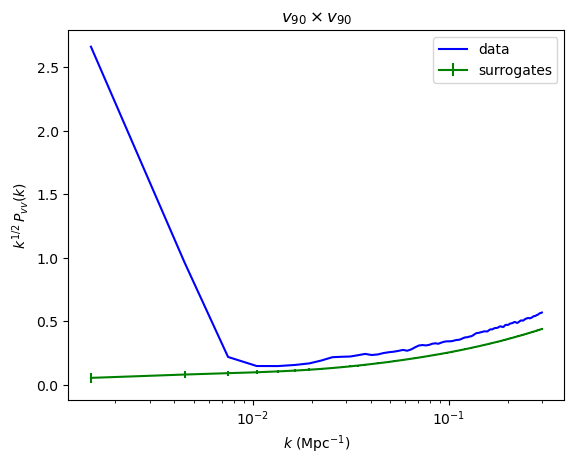

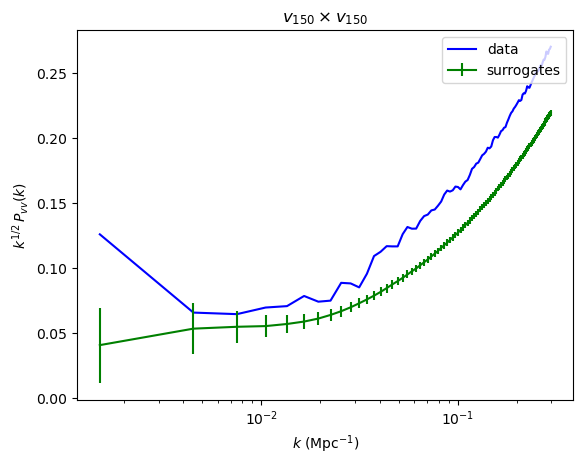

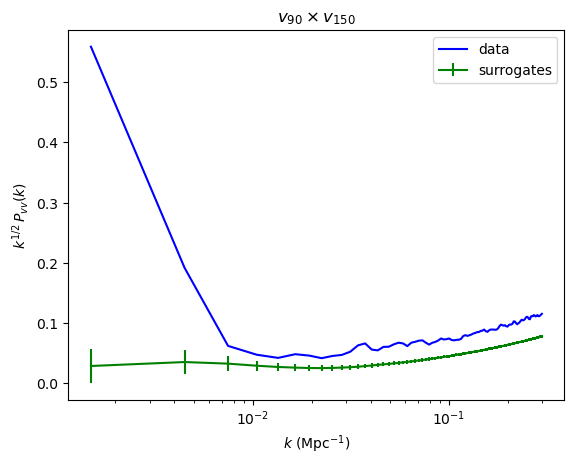

In [8]:
def plot_pvv(ifreq1, ifreq2, title):
    t = kbin_centers**0.5
    plt.plot(kbin_centers, t * pvv_data[ifreq1,ifreq2], label='data', color='blue')
    plt.errorbar(kbin_centers, t * pvv_surr[ifreq1,ifreq2,:], yerr=t*dpvv_surr[ifreq1,ifreq2,:], label = f'surrogates', color='green', ls='-',)
    # Uncomment to show mocks (should be another estimate of reconstruction noise, see above)
    # plt.plot(kbin_centers, t*pvv_mocks[ifreq1,ifreq2,:], label='mocks', color='orange')
    plt.legend(loc='upper right')
    plt.title(title)
    plt.xlabel(r'$k$ (Mpc$^{-1}$)')
    plt.ylabel(r'$k^{1/2} \, P_{vv}(k)$')
    plt.xscale('log')
    plt.show()

plot_pvv(0, 0, r'$v_{90} \times v_{90}$')
plot_pvv(1, 1, r'$v_{150} \times v_{150}$')
plot_pvv(0, 1, r'$v_{90} \times v_{150}$')

## More detailed comparisons between mocks and surrogates (mean and covariance of $P_{gg}$)
 - The power spectrum $P_{gg}(k)$ agrees to $\lesssim 5$%.
 - The statistical error on $P_{gg}(k)$ agrees to a few percent at low $k$, but the disagreement rises to $\sim 20$% at high $k$.
 - Correlations between $P_{gg}$ bandpowers agree pretty well.
 - This level of agreement seems good enough to use surrogates to assign statistical errors.
 - Note that the mocks do not contain BAO -- this is why the ratio $P_{\rm mock}/P_{\rm surr}$ has "wiggles".

In [9]:
pgg_mock_mean = np.mean(pk_mocks[:,0,0,:], axis=0)        # shape (nkbins,)
pgg_mock_rms = np.var(pk_mocks[:,0,0,:], axis=0)**0.5     # shape (nkbins,)
pgg_mock_cov = np.cov(pk_mocks[:,0,0,:].T)                # shape (nkbins, nkbins)

pgg_surr_mean = np.mean(pk_surr[:,1,0,0,:], axis=0)        # shape (nkbins,)
pgg_surr_rms = np.var(pk_surr[:,1,0,0,:], axis=0)**0.5     # shape (nkbins,)
pgg_surr_cov = np.cov(pk_surr[:,1,0,0,:].T)                # shape (nkbins, nkbins)

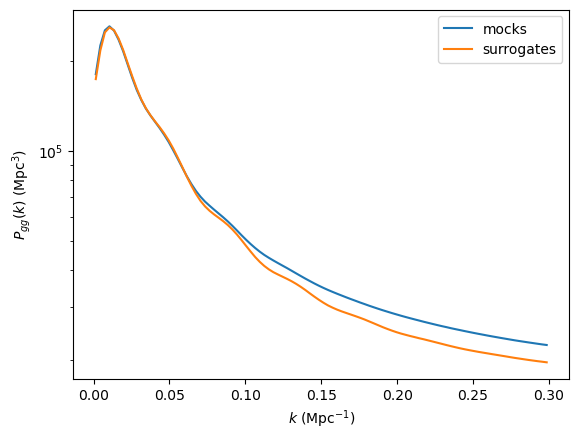

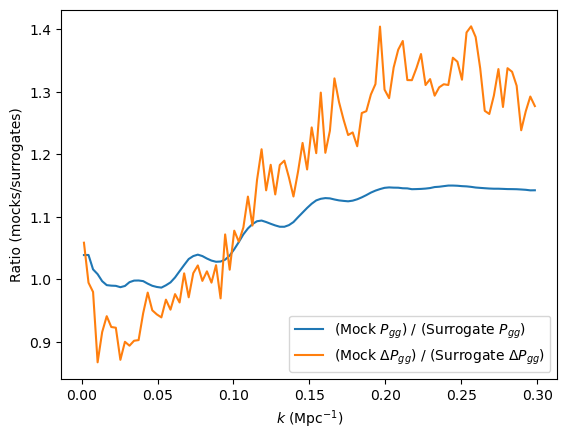

In [10]:
plt.plot(kbin_centers, pgg_mock_mean, label='mocks')
plt.plot(kbin_centers, pgg_surr_mean, label='surrogates')
plt.legend(loc='upper right')
plt.xlabel(r'$k$ (Mpc$^{-1}$)')
plt.ylabel(r'$P_{gg}(k)$ (Mpc$^3$)')
plt.yscale('log')
plt.show()

plt.plot(kbin_centers, pgg_mock_mean / pgg_surr_mean, label=r'(Mock $P_{gg}$) / (Surrogate $P_{gg}$)')
plt.plot(kbin_centers, pgg_mock_rms / pgg_surr_rms, label=r'(Mock $\Delta P_{gg}$) / (Surrogate $\Delta P_{gg}$)')
plt.xlabel(r'$k$ (Mpc$^{-1}$)')
plt.ylabel('Ratio (mocks/surrogates)')
plt.legend(loc='lower right')
plt.show()

In [11]:
def plot_r(pk_cov, delta, label, color, ls):
    k = kbin_centers[delta:]
    r = [ (pk_cov[b,b+delta] / (pk_cov[b,b] * pk_cov[b+delta,b+delta])**0.5) for b in range(nkbins-delta) ]
    plt.plot(k, r, label=label, color=color, ls=ls)

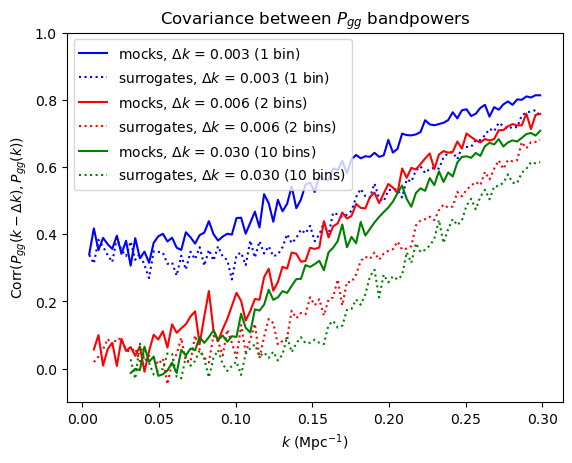

In [12]:
for (delta,color) in [(1,'blue'),(2,'red'),(10,'green')]:
    dk = kbin_edges[delta]
    s = 's' if (delta != 1) else ''
    l = f'$\\Delta k$ = {dk:.03f} ({delta} bin{s})'
    plot_r(pgg_mock_cov, delta, f'mocks, {l}', color, '-')
    plot_r(pgg_surr_cov, delta, f'surrogates, {l}', color, ':')

plt.xlabel(r'$k$ (Mpc$^{-1}$)')
plt.ylabel(r'Corr($P_{gg}(k-\Delta k),P_{gg}(k)$)')
plt.title(r'Covariance between $P_{gg}$ bandpowers')
plt.ylim(-0.1, 1)
plt.legend(loc = 'upper left')
plt.show()